https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn import linear_model, neighbors, datasets, preprocessing, metrics, svm
from sklearn.cluster import KMeans
import sklearn.metrics as sm
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [125]:
# Utilizaremos solo imagenes de 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1, color=False, download_if_missing=True)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin dividirr en subconjuntos
X = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("h, w: (%d, %d)" % (h, w))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)

Total dataset size:
h, w: (125, 94)
n_samples: 1288
n_classes: 7


In [126]:
print(target_names)
print(X.shape)
print(y.shape)
print(y[0])
print(X[0])

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
(1288, 125, 94)
(1288,)
5
[[0.99607843 0.99607843 0.9986928  ... 0.21699347 0.20261438 0.20653595]
 [0.99607843 0.9973857  0.99607843 ... 0.22222222 0.20261438 0.20653595]
 [0.9986928  0.9973857  0.99346405 ... 0.2248366  0.20522876 0.20522876]
 ...
 [0.3150327  0.29542485 0.2535948  ... 0.39346406 0.37908497 0.37124184]
 [0.29934642 0.2875817  0.2535948  ... 0.38562092 0.38300657 0.38300657]
 [0.27973858 0.27320263 0.25751635 ... 0.38431373 0.38039216 0.38039216]]


In [127]:
#Funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

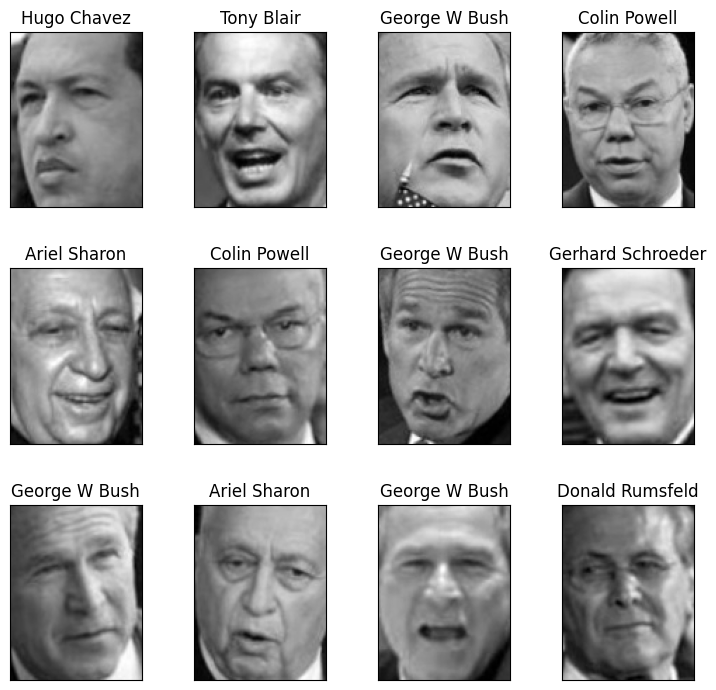

In [128]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)

In [129]:
print(X[0])

[[0.99607843 0.99607843 0.9986928  ... 0.21699347 0.20261438 0.20653595]
 [0.99607843 0.9973857  0.99607843 ... 0.22222222 0.20261438 0.20653595]
 [0.9986928  0.9973857  0.99346405 ... 0.2248366  0.20522876 0.20522876]
 ...
 [0.3150327  0.29542485 0.2535948  ... 0.39346406 0.37908497 0.37124184]
 [0.29934642 0.2875817  0.2535948  ... 0.38562092 0.38300657 0.38300657]
 [0.27973858 0.27320263 0.25751635 ... 0.38431373 0.38039216 0.38039216]]


## Comenzamos el ejercicio 2 a partir de acá, vamos a empezar encontrando el PCA. ##

In [130]:
X_1D = lfw_people.data

pca = PCA()
pca.fit(X_1D)
explained_var = np.cumsum(pca.explained_variance_ratio_)

# elegir cantidad de componentes que sumen al menos el 80%
n_components = np.argmax(explained_var >= 0.80) + 1 #np.argmax nos devuelve un array booleano donde marca True a partir del 80%
# Suma 1 porque los índices en Python arrancan en cero, pero en PCA hablamos de “cantidad de componentes” que empieza en 1.
print(f"Cantidad de componentes seleccionados para >80% varianza: {n_components}")

# volver a entrenar con la cantidad correcta
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_1D)


Cantidad de componentes seleccionados para >80% varianza: 41


In [131]:
#A partir de X_pca vamos a realizar el train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=55 , stratify=y
) #el valor y queda asi como está porque ya está hecho un array de 1D con un target


Mejor combinación de parámetros: {'C': 0.1, 'solver': 'lbfgs'}
Mejor accuracy en validación cruzada: 0.7845
Accuracy sobre el conjunto de prueba: 0.8062


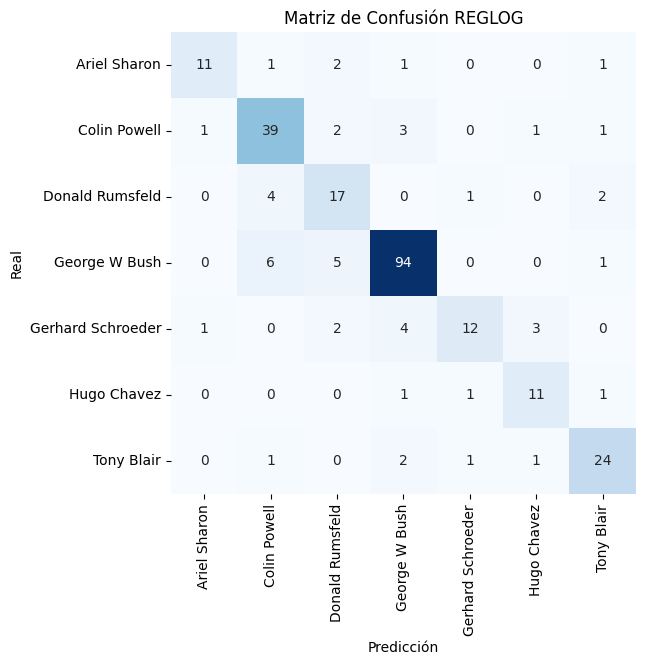

In [132]:
#Ahora determinaremos un modelo basado en una regresión logistica.
reglog = linear_model.LogisticRegression(max_iter=10000)

# Definimos el grid de parámetros
param_grid = {
    'C': [0.01, 0.1, 1, 2, 5, 10, 50, 100],
    'solver': ['lbfgs', 'saga', 'liblinear']
}
grid_search = GridSearchCV(estimator=reglog, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenamos
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo
best_logreg = grid_search.best_estimator_

# Predecimos
y_pred_reglog = best_logreg.predict(X_test)

# Mostramos resultados
print(f"Mejor combinación de parámetros: {grid_search.best_params_}")
print(f"Mejor accuracy en validación cruzada: {grid_search.best_score_:.4f}")
print(f"Accuracy sobre el conjunto de prueba: {accuracy_score(y_test, y_pred_reglog):.4f}")


#Matriz de Confusión
CM_reglog = confusion_matrix(y_test, y_pred_reglog)
plt.figure(figsize= (6,6))
sns.heatmap(CM_reglog, annot=True , fmt ='d', cmap='Blues',cbar=False, xticklabels=target_names, yticklabels =target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión REGLOG')
plt.show()


**punto 4 **: Vamos a utilizar el modelo de KNN

El valor del accuracy del modelo KNN original es : 0.562015503875969


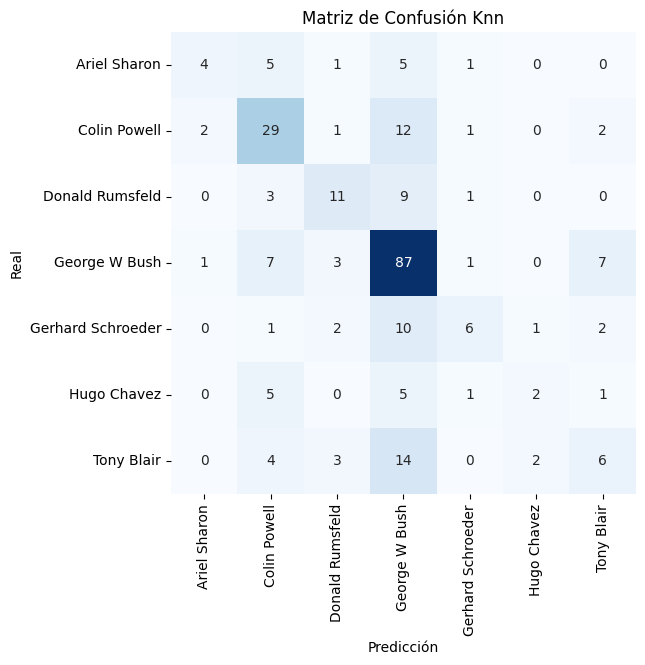

In [133]:
# Lo primero que voy a hacer es utilizar un valor de k, yo utilizare 5 para evitar clases iguales
# Vamos a utilizar el primer dataframe original para realizar el primer modelo de KNN
n_neighbors = 7
knn_model = neighbors.KNeighborsClassifier(n_neighbors, weights= "distance") #elijo uniform para ambos modelos
knn_model.fit(X_train, y_train)
ypred_KNN = knn_model.predict(X_test)
print("El valor del accuracy del modelo KNN original es :", accuracy_score(y_test,ypred_KNN))
#Matriz de confusión para KNN
CM_knn = confusion_matrix(y_test, ypred_KNN)
plt.figure(figsize= (6,6))
sns.heatmap(CM_knn, annot=True , fmt ='d', cmap='Blues',cbar=False, xticklabels=target_names, yticklabels =target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Knn')
plt.show()

Mejor combinación de parámetros: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Mejor accuracy en validación cruzada: 0.7893
Accuracy sobre el conjunto de prueba: 0.8101


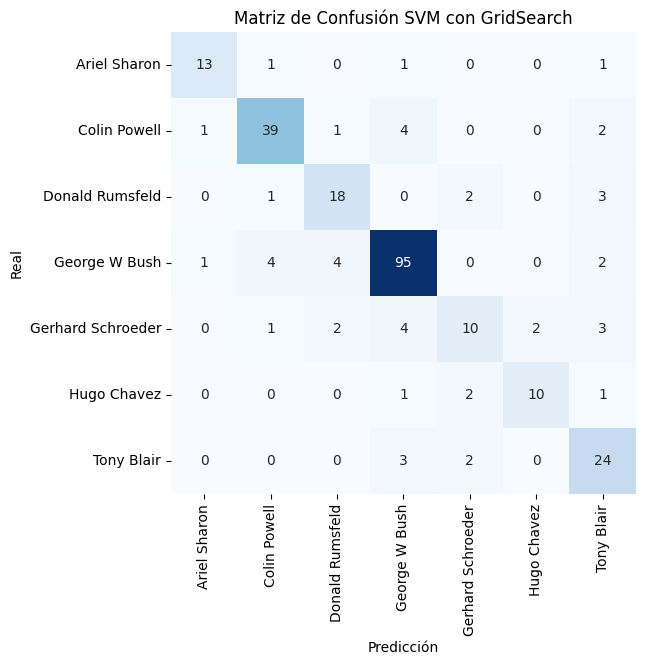

In [134]:

# Definimos el modelo base
svc = svm.SVC()

# Definimos los rangos de búsqueda de hiperparámetros
param_grid = {
    'C': [0.1, 1, 5, 10, 20, 50],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Configuramos GridSearch
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenamos
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo
best_svm = grid_search.best_estimator_

# Predecimos
ypred_svm = best_svm.predict(X_test)

# Mostramos resultados
print(f"Mejor combinación de parámetros: {grid_search.best_params_}")
print(f"Mejor accuracy en validación cruzada: {grid_search.best_score_:.4f}")
print(f"Accuracy sobre el conjunto de prueba: {accuracy_score(y_test, ypred_svm):.4f}")

# Matriz de confusión
CM_svm = confusion_matrix(y_test, ypred_svm)
plt.figure(figsize=(6,6))
sns.heatmap(CM_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión SVM con GridSearch')
plt.show()


## Conclusiones sobre los resultados

-Como conclusiones de los resultados puedo llegar a que tuve que utilizar la función GridSearchCV debido a que los resultados no me llegaban a 0,80 y yo creo que esta bien hecho el PCA, sin embargo capaz hubiese sido mas conveniente que tome por encima del 90% de los datos, eos hubiese dado un mejor resultado, pero bueno aplicando la validación cruzada con el modelo GridSearchCV podemos darnos cuenta cuales son los mejores parametros a utilizar en estos casos.
En los modelos de RegLOG y SVM podemos ver que los resultados pasan por encima de 0,80 porque sirven para predecir modelos de imagenes con grandes cantidades de clases como lo es este, en especial el SVM es mejor.
Para el caso de KNN nos da muy mal resultado porque no sirve bien para trabajar con tantas cantidades de clases, , probablemente debido a la cercanía de puntos en espacios tan complejos, lo cual dificulta una correcta agrupación.
También podemos notar que dependiendo de los datos random que tome el conjunto de test split y train nos garantiza el exito del modelo.